In [26]:
# !pip install vaderSentiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv('/data/elo/khanglg/Sarcasm-Detection/data/sarcasm_dataset.csv')
X_train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')

# load the labels
y_train = pd.read_csv('../data/train_labels.csv')
y_test = pd.read_csv('../data/test_labels.csv')

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# VAD Lexicon loading
vad_lexicon = pd.read_csv('../data/NRC-VAD-Lexicon.txt', sep='	', encoding='utf-8')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/elo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from transformers import pipeline

# Load Emotion Classification Model
try:
    emotion_classifier = pipeline("text-classification", 
                                  model="j-hartmann/emotion-english-distilroberta-base", 
                                  return_all_scores=True)
except Exception as e:
    print(f"Warning: Emotion classification not available - {str(e)}")
    emotion_classifier = None  # Handle cases where model fails to load

# Function to Extract Emotion Scores
def get_emotion_scores(text):
    """Extract emotion scores from a given text using a transformer-based model."""
    if emotion_classifier is None:
        # Return default values when classifier is not available
        default_emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        return {emotion: 0.0 for emotion in default_emotions}

    emotions = emotion_classifier(text)[0]
    return {e['label'].lower(): e['score'] for e in emotions}

/data/elo/.conda/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-20 17:57:39.625585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742468259.641750 1632192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742468259.647143 1632192 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742468259.660707 1632192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W00

In [3]:
emotion_classifier

In [4]:
emotion_classifier("I am so happy to see you!")

[[{'label': 'anger', 'score': 0.001085096737369895},
  {'label': 'disgust', 'score': 0.00040288790478371084},
  {'label': 'fear', 'score': 0.0003686379350256175},
  {'label': 'joy', 'score': 0.9827131032943726},
  {'label': 'neutral', 'score': 0.0016955849714577198},
  {'label': 'sadness', 'score': 0.0019903003703802824},
  {'label': 'surprise', 'score': 0.011744407936930656}]]

/tmp/ipykernel_1632192/62980018.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Unigram", data=uni_df, palette="Blues_r")


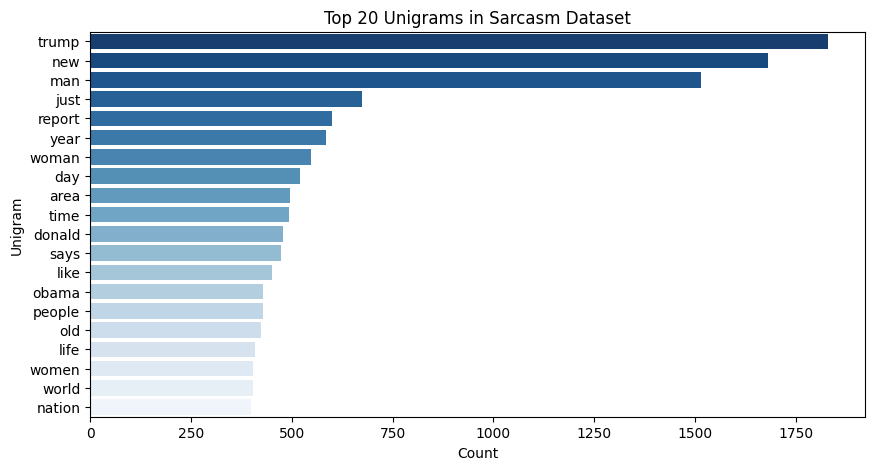

/tmp/ipykernel_1632192/62980018.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Bigram", data=bi_df, palette="Reds_r")


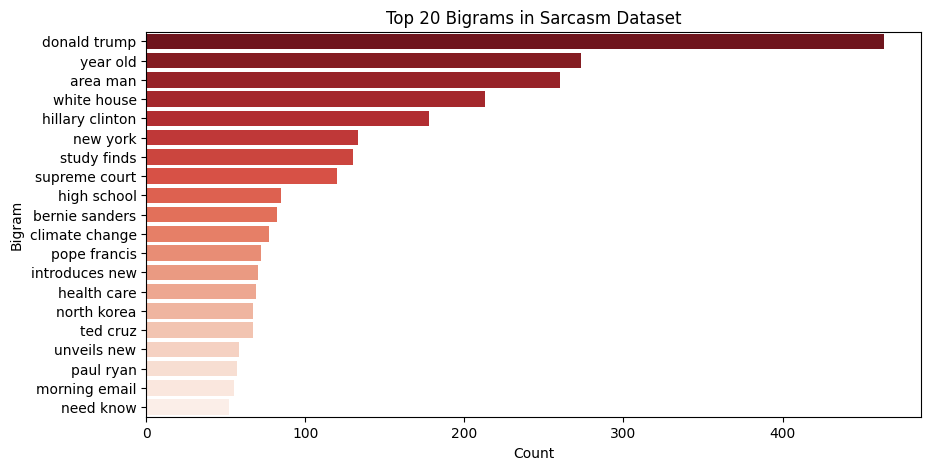

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
def get_ngrams(texts, n=2, top_k=20):
    """
    Extracts the top-k most frequent n-grams (unigrams or bigrams).
    """
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words="english")
    X = vectorizer.fit_transform(texts)
    
    
    ngram_counts = np.asarray(X.sum(axis=0)).flatten()
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts))
    
    
    sorted_ngrams = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return sorted_ngrams


unigrams = get_ngrams(data["headline"], n=1, top_k=20)
bigrams = get_ngrams(data["headline"], n=2, top_k=20)

# Convert to DataFrame for visualization
uni_df = pd.DataFrame(unigrams, columns=["Unigram", "Count"])
bi_df = pd.DataFrame(bigrams, columns=["Bigram", "Count"])


plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Unigram", data=uni_df, palette="Blues_r")
plt.title("Top 20 Unigrams in Sarcasm Dataset")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bi_df, palette="Reds_r")
plt.title("Top 20 Bigrams in Sarcasm Dataset")
plt.show()

In [6]:
vad_lexicon = pd.read_csv('../data/NRC-VAD-Lexicon.txt', sep='	', encoding='utf-8')
# Get the actual column names from the file
column_names = vad_lexicon.columns
word_col = column_names[0]  # First column should be words
valence_col = column_names[1]  # Second column should be valence
arousal_col = column_names[2]  # Third column should be arousal
dominance_col = column_names[3]  # Fourth column should be dominance

vad_dict = dict(zip(vad_lexicon[word_col], 
                    zip(vad_lexicon[valence_col],
                        vad_lexicon[arousal_col],
                        vad_lexicon[dominance_col])))

def get_vad_scores(text):
    words = text.lower().split()
    v_scores = []
    a_scores = []
    d_scores = []
    
    for word in words:
        if word in vad_dict:
            v, a, d = vad_dict[word]
            v_scores.append(float(v))
            a_scores.append(float(a))
            d_scores.append(float(d))
    
    return [np.mean(s) if s else 0 for s in [v_scores, a_scores, d_scores]]

In [7]:
sample_text = "I absolutely love this, it's amazing!"
vad_scores = get_vad_scores(sample_text)
print(f"VAD Scores: Valence={vad_scores[0]}, Arousal={vad_scores[1]}, Dominance={vad_scores[2]}")

VAD Scores: Valence=1.0, Arousal=0.519, Dominance=0.673


In [8]:
import pandas as pd
import spacy
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
text = "I absolutely love this, it's amazing!"
doc = nlp(text)

print(vader.polarity_scores(text))
print(doc._.blob.polarity)

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.862}
0.625


In [10]:
POS_tags = list(nlp.get_pipe("tagger").labels)

def process_text(text):
    re = {k: 0 for k in POS_tags}

    spacy_doc = nlp(text)

    # Named entities, polarity, subjectivity
    re["ents_count"] = len(spacy_doc.ents)
    re["polarity"] = spacy_doc._.blob.polarity
    re["subjectivity"] = spacy_doc._.blob.subjectivity

    text_tokens = []

    for token in spacy_doc:
        t = token.lemma_
        re[token.tag_] += 1  

        if token.pos_ == "PUNCT":
            continue

        if token.pos_ == "NUM":
            t = "NUM"
        
        text_tokens.append(t)

    re["cleaned_text"] = text_tokens  # Store processed tokens for TF-IDF

    # Add VADER sentiment scores
    sentiment_scores = vader.polarity_scores(text)
    re["vader_neg"] = sentiment_scores["neg"]
    re["vader_neu"] = sentiment_scores["neu"]
    re["vader_pos"] = sentiment_scores["pos"]
    re["vader_compound"] = sentiment_scores["compound"]

    # Add VAD scores
    vad_scores = get_vad_scores(text)
    re["vad_valence"], re["vad_arousal"], re["vad_dominance"] = vad_scores

    # Add Transformer-based emotion scores
    emotion_scores = get_emotion_scores(text)
    re.update(emotion_scores)

    return re

def df_process_text(row):
    return pd.Series(process_text(row["headline"]))

In [11]:
from tqdm.auto import tqdm

tqdm.pandas()

In [12]:
X_train = X_train.join(X_train.progress_apply(df_process_text, axis=1))

100%|██████████| 19952/19952 [03:08<00:00, 106.10it/s]


In [13]:
X_test = X_test.join(X_test.progress_apply(df_process_text, axis=1))

100%|██████████| 8551/8551 [01:19<00:00, 107.59it/s]


In [14]:
X_train.head()

,headline,$,'',",",-LRB-,-RRB-,.,:,ADD,AFX,...,vad_valence,vad_arousal,vad_dominance,anger,disgust,fear,joy,neutral,sadness,surprise
0,delta airlines counter agent assures man he wi...,0,0,0,0,0,0,0,0,0,...,0.628500,0.386667,0.617333,0.023735,0.007928,0.025703,0.022274,0.543145,0.364578,0.012637
1,longtime employee given small pewter object,0,0,0,0,0,0,0,0,0,...,0.482600,0.324800,0.368600,0.061977,0.599894,0.026167,0.038430,0.197572,0.043619,0.032341
2,winneshiek county stadium indeed ready to rock,0,0,0,0,0,0,0,0,0,...,0.626750,0.417750,0.590250,0.006138,0.001556,0.015124,0.177406,0.502278,0.028224,0.269273
3,huckabee backs denying abortion to 10-year-old...,0,0,0,0,0,0,0,0,0,...,0.186000,0.601000,0.388667,0.244724,0.555785,0.017807,0.004751,0.130269,0.041974,0.004690
4,several injured after 'unauthorized' vehicle e...,0,1,0,0,0,0,0,0,0,...,0.446333,0.505333,0.442333,0.065475,0.015037,0.340561,0.003545,0.052087,0.503945,0.019350


In [28]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    max_features=5000,
    ngram_range=(1,2)
)
temp = vectorizer.fit_transform(X_train["cleaned_text"])
train_df_tfidf = pd.DataFrame(
    temp.toarray(), columns=vectorizer.get_feature_names_out()
)

temp = vectorizer.transform(X_test["cleaned_text"])
test_df_tfidf = pd.DataFrame(temp.toarray(), columns=vectorizer.get_feature_names_out())

/data/elo/.conda/envs/sd/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
train_df_tfidf

,,#,$,$ NUM,%,% of,&,',' 80,' NUM,...,your life,yourself,youth,youtube,z,zika,zone,zoo,zuckerberg,
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19947,0.0,0.0,0.247053,0.247250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19948,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19949,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19950,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_train['headline'][0]

'delta airlines counter agent assures man he will never see his family again'

In [18]:
transfer_columns = [c for c in X_train.columns if c not in ["headline", "cleaned_text"]]

train_df_fin = pd.concat([train_df_tfidf, X_train[transfer_columns].add_prefix('I_')], axis=1)
test_df_fin = pd.concat([test_df_tfidf, X_test[transfer_columns].add_prefix('I_')], axis=1)

In [31]:
train_df_fin

,,#,$,$ NUM,%,% of,&,',' 80,' NUM,...,I_vad_valence,I_vad_arousal,I_vad_dominance,I_anger,I_disgust,I_fear,I_joy,I_neutral,I_sadness,I_surprise
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628500,0.386667,0.617333,0.023735,0.007928,0.025703,0.022274,0.543145,0.364578,0.012637
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.482600,0.324800,0.368600,0.061977,0.599894,0.026167,0.038430,0.197572,0.043619,0.032341
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.626750,0.417750,0.590250,0.006138,0.001556,0.015124,0.177406,0.502278,0.028224,0.269273
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.186000,0.601000,0.388667,0.244724,0.555785,0.017807,0.004751,0.130269,0.041974,0.004690
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.446333,0.505333,0.442333,0.065475,0.015037,0.340561,0.003545,0.052087,0.503945,0.019350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19947,0.0,0.0,0.247053,0.247250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.513000,0.589000,0.545000,0.037250,0.005420,0.121616,0.007608,0.500907,0.277526,0.049672
19948,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366571,0.484143,0.384571,0.262914,0.111735,0.022823,0.002498,0.094160,0.500027,0.005842
19949,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.629167,0.446000,0.625500,0.011058,0.001662,0.007639,0.020618,0.801490,0.027086,0.130447
19950,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.537667,0.452500,0.540000,0.025853,0.089839,0.046290,0.014635,0.443515,0.045652,0.334216


In [19]:
train_y = y_train['is_sarcastic']

In [20]:
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report

In [21]:
model = LogisticRegression(class_weight="balanced", max_iter=500, C=2)
model.fit(train_df_fin,train_y)

LogisticRegression(C=2, class_weight='balanced', max_iter=500)

In [22]:
from sklearn.metrics import f1_score

In [23]:
y_train_pred = model.predict(train_df_fin)

score_train = f1_score(train_y, y_train_pred, average="macro")

print(score_train)
print(classification_report(train_y, y_train_pred))

0.9104303233008979
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     10400
           1       0.90      0.92      0.91      9552

    accuracy                           0.91     19952
   macro avg       0.91      0.91      0.91     19952
weighted avg       0.91      0.91      0.91     19952



In [24]:
test_y = y_test['is_sarcastic']


In [25]:
y_test_pred = model.predict(test_df_fin)

score_test = f1_score(test_y, y_test_pred, average="macro")

print(score_test)
print(classification_report(test_y, y_test_pred))

0.8501687463529697
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4551
           1       0.84      0.85      0.84      4000

    accuracy                           0.85      8551
   macro avg       0.85      0.85      0.85      8551
weighted avg       0.85      0.85      0.85      8551

